In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## Import the libraries and data

In [0]:
%tensorflow_version 1.14
import numpy as np
import pandas as pd
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
from os import listdir
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.mobilenet import MobileNet
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

Using TensorFlow backend.


In [0]:
#Read the sample_labels.csv into a pandas dataframe
all_xray_df = pd.read_csv('drive/My Drive/Chest_data/sample/sample_labels.csv')
all_image_paths = {os.path.basename(f): f  for f in listdir("drive/My Drive/Chest_data/sample/images")   }      
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df['Patient Age'] = all_xray_df['Patient Age'].map(lambda x: int(x[:-1]))
all_xray_df.sample(3)

Scans found: 5606 , Total Headers 5606


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y,path
5298,00028522_000.png,No Finding,0,28522,53,F,PA,2544,3056,0.139,0.139,00028522_000.png
3119,00015386_000.png,Atelectasis|Effusion,0,15386,58,F,PA,2646,2797,0.143,0.143,00015386_000.png
4186,00020523_000.png,Infiltration,0,20523,37,F,PA,2502,2705,0.143,0.143,00020523_000.png


## Visualisation

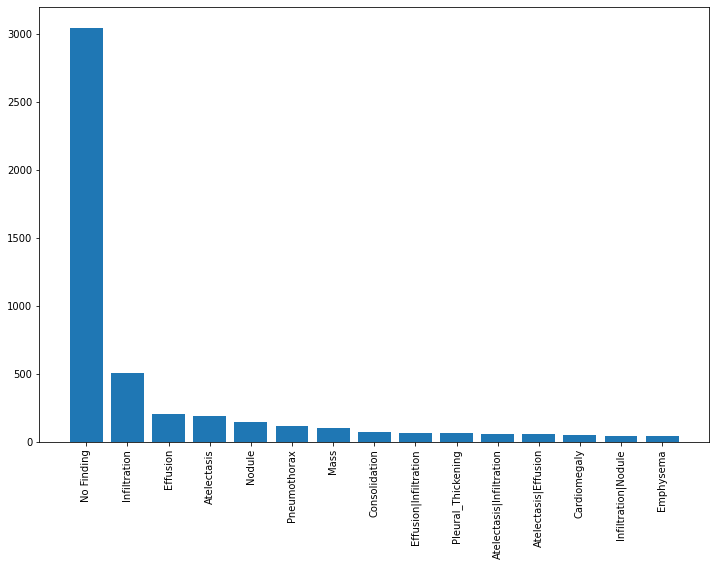

In [0]:
label_counts = all_xray_df['Finding Labels'].value_counts()[:15]
fig, ax1 = plt.subplots(1,1,figsize = (12, 8))
ax1.bar(np.arange(len(label_counts))+0.5, label_counts)
ax1.set_xticks(np.arange(len(label_counts))+0.5)
_ = ax1.set_xticklabels(label_counts.index, rotation = 90)

## Pre Processing

In [0]:
# Since the image may contain multiple disease labels
# Create a list of all disesases and append a new column named output to the x_ray dataframe
all_xray_df['disease_vec']=all_xray_df['Finding Labels'].apply(lambda x: x.split('|'))

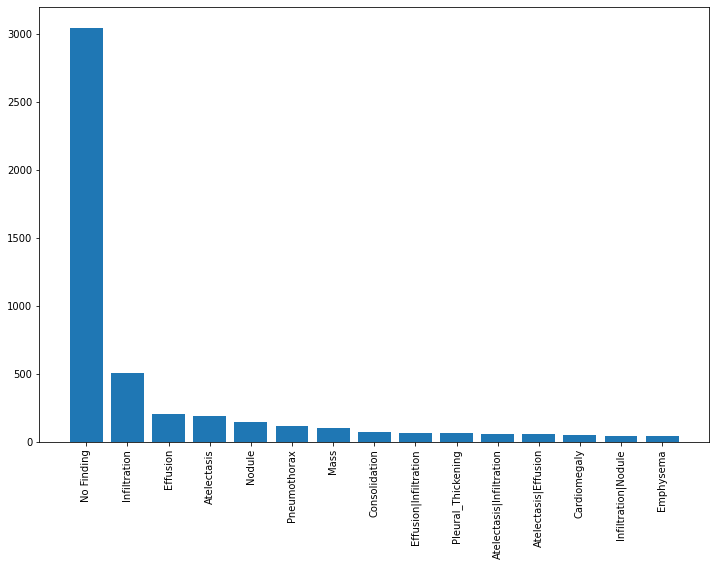

In [0]:
# since the dataset is very unbiased, we can resample it to be a more reasonable collection
# weight is 0.1 + number of findings
sample_weights = all_xray_df['Finding Labels'].map(lambda x: len(x.split('|')) if len(x)>0 else 0).values + 4e-2
sample_weights /= sample_weights.sum()
all_xray_df = all_xray_df.sample(5606, weights=sample_weights)

label_counts = all_xray_df['Finding Labels'].value_counts()[:15]
fig, ax1 = plt.subplots(1,1,figsize = (12, 8))
ax1.bar(np.arange(len(label_counts))+0.5, label_counts)
ax1.set_xticks(np.arange(len(label_counts))+0.5)
_ = ax1.set_xticklabels(label_counts.index, rotation = 90)

In [0]:
all_labels=['Atelectasis','Cardiomegaly','Effusion','Infiltration','Mass','Nodule','Pneumonia','Pneumothorax','Consolidation','Edema','Emphysema','Fibrosis','Pleural Thickening','Hernia']

## Splitting the dataset

In [0]:
# 20% of the data will be used for testing of model performance
# random state is set so as to get the same split everytime
# stratify is used to have equal proportion of output label in training and validation set
train_df, valid_df = train_test_split(all_xray_df, 
                                   test_size = 0.25, 
                                   random_state = 2018,
                                   stratify = all_xray_df['Finding Labels'].map(lambda x: x[:4]))
print('train', train_df.shape[0], 'validation', valid_df.shape[0])

train 4204 validation 1402


In [0]:
#creating an Image Data generator
IMG_SIZE = (128, 128)
core_idg = ImageDataGenerator(samplewise_center=True, 
                              samplewise_std_normalization=True, 
                              horizontal_flip = True, 
                              vertical_flip = False, 
                              height_shift_range= 0.05, 
                              width_shift_range=0.1, 
                              rotation_range=5, 
                              shear_range = 0.1,
                              fill_mode = 'reflect',
                              zoom_range=0.15,
                              validation_split = 0.1)

In [0]:
# obtaing the training images using the above generator
train_gen = core_idg.flow_from_dataframe(
        dataframe=train_df,
        directory='drive/My Drive/Chest_data/sample/images',
        x_col='path',
        y_col='disease_vec',
        target_size=(128, 128),
        batch_size=32,
        class_mode='categorical',subset='training')

Found 3784 validated image filenames belonging to 15 classes.


In [0]:
# print the output classes in ImageDataGenerator train_gen
train_gen.class_indices.keys()

In [0]:
# obtaing the validation images using the above generator
valid_gen = core_idg.flow_from_dataframe(
        dataframe=train_df,
        directory='drive/My Drive/Chest_data/sample/images',
        x_col='path',
        y_col='disease_vec',
        target_size=(128, 128),
        batch_size=32,
        class_mode='categorical',subset='validation')

Found 420 validated image filenames belonging to 15 classes.


In [0]:
#select a batch of images used for prediction on trained model
test_X, test_Y = next(core_idg.flow_from_dataframe(
        dataframe=train_df,
        directory='drive/My Drive/Chest_data/sample/images',
        x_col='path',
        y_col='disease_vec',
        target_size=(128, 128),
        batch_size=32,
        class_mode='categorical')) # one big batch

Found 4204 validated image filenames belonging to 15 classes.


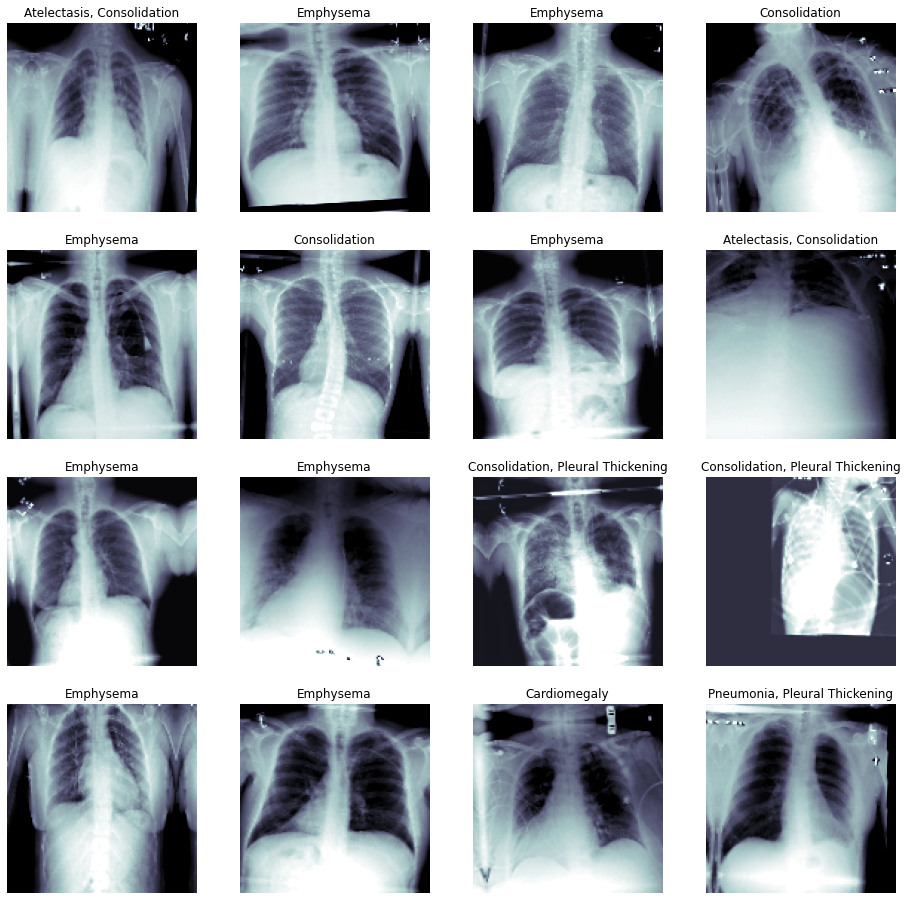

In [0]:
t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone', vmin = -1.5, vmax = 1.5)
    c_ax.set_title(', '.join([n_class for n_class, n_score in zip(all_labels, c_y) 
                             if n_score>0.5]))
    c_ax.axis('off')

## Creating models

In [0]:
# create a function to return a mobileNetModel with the output layer having 15 output units
base_mobilenet_model = MobileNet(input_shape =  t_x.shape[1:], 
                                 include_top = False, weights = None)
multi_disease_model = Sequential()
multi_disease_model.add(base_mobilenet_model)
multi_disease_model.add(GlobalAveragePooling2D())
multi_disease_model.add(Dropout(0.5))
multi_disease_model.add(Dense(512))
multi_disease_model.add(Dropout(0.5))
multi_disease_model.add(Dense(15, activation = 'sigmoid'))












Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_128 (Model)   (None, 4, 4, 1024)        3228864   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1024)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
______________________________

In [0]:
# choose an appropriate model and compile
multi_disease_model.compile(optimizer = 'adam', loss = 'binary_crossentropy',
                           metrics = ['binary_accuracy', 'mae'])
# print the model details
multi_disease_model.summary()

In [0]:
# creating a callback to store the best model
weight_path="{}_weights.best.hdf5".format('xray_class')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=3)
callbacks_list = [checkpoint, early]

## Training

In [0]:
# start training the model
multi_disease_model.fit_generator(train_gen, 
                                  steps_per_epoch=100,
                                  validation_data = (test_X, test_Y), 
                                  epochs = 3, 
                                  callbacks = callbacks_list)



Epoch 1/3
100/100 [==============================] - 504s 5s/step - loss: 0.3142 - binary_accuracy: 0.9108 - mean_absolute_error: 0.1233 - val_loss: 1.1005 - val_binary_accuracy: 0.9083 - val_mean_absolute_error: 0.0929

Epoch 00001: val_loss improved from inf to 1.10053, saving model to xray_class_weights.best.hdf5
Epoch 2/3
100/100 [==============================] - 154s 2s/step - loss: 0.2621 - binary_accuracy: 0.9213 - mean_absolute_error: 0.1189 - val_loss: 0.4535 - val_binary_accuracy: 0.9042 - val_mean_absolute_error: 0.1376

Epoch 00002: val_loss improved from 1.10053 to 0.45354, saving model to xray_class_weights.best.hdf5
Epoch 3/3
100/100 [==============================] - 63s 632ms/step - loss: 0.2349 - binary_accuracy: 0.9227 - mean_absolute_error: 0.1192 - val_loss: 0.2933 - val_binary_accuracy: 0.9000 - val_mean_absolute_error: 0.1703

Epoch 00003: val_loss improved from 0.45354 to 0.29328, saving model to xray_class_weights.best.hdf5


## Testing the performance of the model

In [0]:
# load the best weights
multi_disease_model.load_weights(weight_path)

In [0]:
# predict on the test_X batch of the validation set
res = multi_disease_model.evaluate(test_X,test_Y, batch_size = 32, verbose = True)
print('loss = ',res[0])
print('Binary accuracy = ',res[1])
print('Mean absolute error',res[2])

32/32 [==============================] - 0s 869us/step
loss =  0.2932758927345276
Binary accuracy =  0.8999999761581421
Mean absolute error 0.17028623819351196
